In [1]:
#import opencv and numpy
import cv2  
import numpy as np
import random
import math
from matplotlib import pyplot as plt

#trackbar callback function to update HSV value
def callback(x):
    global H_low, H_high, S_low, S_high, V_low, V_high
    #assign trackbar position value to H, S, V High and low variables
    H_low = cv2.getTrackbarPos('low H', 'controls')
    H_high = cv2.getTrackbarPos('high H', 'controls')
    S_low = cv2.getTrackbarPos('low S', 'controls')
    S_high = cv2.getTrackbarPos('high S', 'controls')
    V_low = cv2.getTrackbarPos('low V', 'controls')
    V_high = cv2.getTrackbarPos('high V', 'controls')

#create a separate window named 'controls' for trackbar
cv2.namedWindow('controls', 2)
cv2.resizeWindow("controls", 550, 300)

#global variables
H_low = 0
H_high = 179
S_low = 0
S_high = 255
V_low = 0
V_high = 255

#create trackbars for high, low H, S, V 
cv2.createTrackbar('low H', 'controls', 0, 179, callback)
cv2.createTrackbar('high H', 'controls', 179, 179, callback)
cv2.createTrackbar('low S', 'controls', 0, 255, callback)
cv2.createTrackbar('high S', 'controls', 255, 255, callback)
cv2.createTrackbar('low V', 'controls', 0, 255, callback)
cv2.createTrackbar('high V', 'controls', 255, 255, callback)



#read source image
img = cv2.imread("test.jpg")

#scale down the image by a factor of 4
width = img.shape[1] // 2
height = img.shape[0] // 2
img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

#convert source image to HSV color mode
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


while(1):
    #define the range for HSV values
    hsv_low = np.array([H_low, S_low, V_low], np.uint8)
    hsv_high = np.array([H_high, S_high, V_high], np.uint8)
    
    #create mask for the specified HSV range
    mask = cv2.inRange(hsv, hsv_low, hsv_high)
    #masking HSV value selected color becomes black
    res = cv2.bitwise_and(img, img, mask=mask)
    
    #show images
    cv2.imshow('mask', mask)
    cv2.imshow('res', res)
    
    #wait for the user to press escape and break the while loop 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
        
#destroy all windows
cv2.destroyAllWindows()

print(H_low, H_high, S_low, S_high, V_low, V_high)


0 44 0 255 127 255


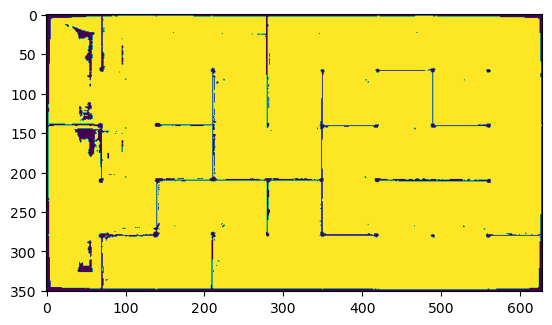

In [2]:
# Filtering noise
def bwareaopen(img, min_area):
    img_inverted = cv2.bitwise_not(img)
    # 获取所有连通区域的标签、统计数据等
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_inverted, connectivity=8)
    
    # 保留面积大于等于指定阈值的区域，移除小的噪点
    filtered_img = np.zeros_like(img_inverted)
    for i in range(1, num_labels):  # 跳过背景（label=0）
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered_img[labels == i] = 255
    
    return cv2.bitwise_not(filtered_img)


def MyCVShow(img):
    while(1):
        cv2.imshow('CVIMG', img)
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            cv2.destroyAllWindows()
            break


mask_filtered = bwareaopen(mask, 40)

plt.imshow(mask)
plt.show()

MyCVShow(mask_filtered)

In [3]:
# class definition
class Node:
    
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y


class Graph:
    
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight  # Assuming it's an undirected graph

    def get_nodes(self):
        return list(self.nodes.values())
    

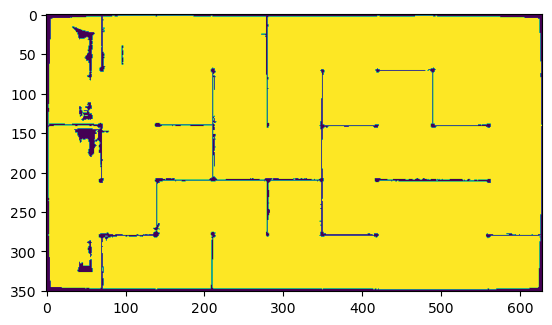

In [4]:
# Nodes, Edges
bfs_image = mask_filtered.copy()

space = np.array(bfs_image).shape[1] / 9
margin = space / 2

bfs_graph = Graph()

# 添加所有结点
for i in range(45):
    row = i // 9
    column = i % 9
    bfs_graph.add_node(i, int(margin+row*space), int(margin+column*space))
    
    
# # 添加所有 edge
for i in range(45):
    row = i // 9
    column = i % 9
    X_current = bfs_graph.nodes[i].x
    Y_current = bfs_graph.nodes[i].y
    # 向右添加 edge
    if column < 9-1:
        no_obstacle = 1
        Y_right = bfs_graph.nodes[i+1].y
        # 检查 →线段 内有无障碍物
        for Y in range(Y_current+1, Y_right):
            if not np.array_equal(bfs_image[X_current][Y], 255):
                no_obstacle = 0
                break  
        if no_obstacle == 1:
            bfs_graph.add_edge(i, i+1, 1)
    # 向下添加 edge
    if row < 5-1:
        no_obstacle = 1
        X_down = bfs_graph.nodes[i+9].x
        # 检查 ↓线段 内有无障碍物
        for X in range(X_current+1, X_down):
            # print(bfs_image[X_current][Y])
            if not np.array_equal(bfs_image[X][Y_current], 255):
                no_obstacle = 0
                break
        if no_obstacle == 1:
            bfs_graph.add_edge(i, i+9, 1)
    

# 绘制所有 node
for Nd in bfs_graph.get_nodes():
    # bfs_image[Nd.x][Nd.y] = [0,255,0]
    cv2.circle(bfs_image, (Nd.y,Nd.x), 3, [0,255,0], -1)
    
    
# # 绘制所有 edge
for i in range(45):
    X_current = bfs_graph.nodes[i].x
    Y_current = bfs_graph.nodes[i].y
    # 绘制 → edge
    if i+1 in bfs_graph.edges[i]:
        Y_right = bfs_graph.nodes[i+1].y
        # for Y in range(Y_current+1, Y_right):
        #     bfs_image[X_current,Y] = [0, 125, 0]
        cv2.line(bfs_image, (Y_current, X_current), (Y_right, X_current), (0, 125, 0), 3)
    # 绘制 ↓ edge
    if i+9 in bfs_graph.edges[i]:
        X_down = bfs_graph.nodes[i+9].x
        # for X in range(X_current+1, X_down):
        #     bfs_image[X,Y_current] = [0, 125, 0]
        cv2.line(bfs_image, (Y_current, X_current), (Y_current, X_down), (0, 125, 0), 3)
        

plt.imshow(mask_filtered)
plt.show()

MyCVShow(bfs_image)

In [5]:
# BFS algorithm
def bfs(graph, start_node_id, end_node_id):

    queue = [start_node_id]
    visited = {start_node_id: None}
    
    while queue:
        current = queue.pop(0)
        
        if current == end_node_id:
            break
        
        for neighbor in graph.edges[current]:
            if neighbor not in visited:
                visited[neighbor] = current
                queue.append(neighbor)
    
    path = []
    while current is not None:
        path.append(current)
        current = visited[current]
    
    path.reverse()
    
    return path


Path: [36, 27, 28, 19, 10, 1, 2, 3, 12, 21, 22, 13, 4, 5, 14, 15, 24, 23, 32, 33, 42, 41, 40, 39, 30, 29, 38, 37]


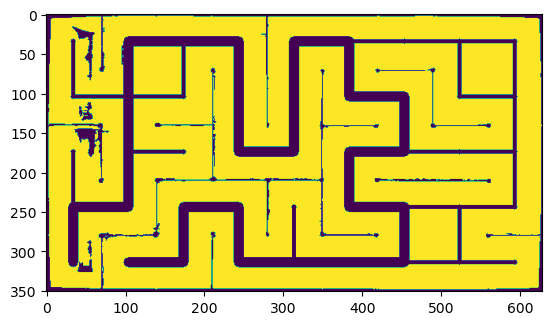

In [6]:
# BFS
path = bfs(bfs_graph, 36, 37)

print(f"Path: {path}")

for i in range(len(path) - 1):
    
    node_current = bfs_graph.nodes[path[i]]
    node_next = bfs_graph.nodes[path[i + 1]]
    cv2.line(bfs_image, (node_current.y, node_current.x), (node_next.y, node_next.x), (0, 0, 255), 12)


plt.imshow(bfs_image)
plt.show()

In [8]:
# moving command based on BFS
moving_command = ""
mouse_direction = 0

# Initial mouse direction
if path[1]-path[0] ==  9:
    mouse_direction = 3
if path[1]-path[0] == -9:
    mouse_direction = 1
if path[1]-path[0] ==  1:
    mouse_direction = 2
if path[1]-path[0] == -1:
    mouse_direction = 4


moving_direction_gcf = 0
for i in range(len(path)):
    if i == len(path)-1:
        break
    if path[i+1]-path[i] ==  9:
        moving_direction_gcf = 3
    if path[i+1]-path[i] == -9:
        moving_direction_gcf = 1
    if path[i+1]-path[i] ==  1:
        moving_direction_gcf = 2
    if path[i+1]-path[i] == -1:
        moving_direction_gcf = 4
  
    if moving_direction_gcf-mouse_direction == 0:
        moving_command += 'f'
    if moving_direction_gcf-mouse_direction == -1:
        moving_command += 'lf'
        mouse_direction -= 1
    if moving_direction_gcf-mouse_direction == 1:
        moving_command += 'rf'
        mouse_direction += 1

    i += 1
    

print(moving_command)

MyCVShow(bfs_image)

frflfffrffrfflflffrfrflfrfrflflfrfrfffflfrf


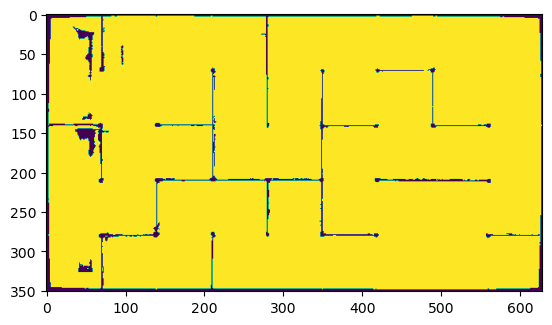

In [18]:
# Occupancy Map
unsafe_kernel_size = 10
unsafe_iterations = 3


kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) # TODO: Use this kernenl to generate un_safe area
eroded_image = cv2.erode(mask_filtered, kernel, iterations=unsafe_iterations)
# extended_area = cv2.subtract(mask_filtered, eroded_image)
# 
# extended_area_gray = cv2.cvtColor(extended_area, cv2.COLOR_BGR2GRAY)

# eroded_image[extended_area_gray > 0] = [255,0,0]

plt.imshow(mask_filtered)
plt.show()

MyCVShow(eroded_image)

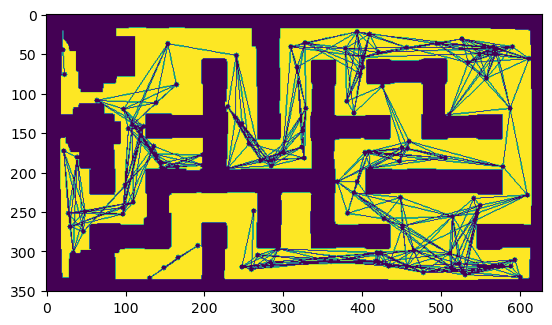

In [19]:
# PRM
start_location = (45,45)
goal_location = (50,570)
iterations = 200
k_connections = 5
max_connection_range = 500


prm_image = eroded_image.copy()
prm_graph = Graph()

seed = random.randint(0,100)
random.seed(seed)


# 返回两点之间线段上的所有点
def points_in_line(x1, y1, x2, y2):

    all_points = []
    
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    
    err = dx - dy
    
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    
    while True:
        all_points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e = err * 2
        if e > -dy:
            err -= dy
            x1 += sx
        if e < dx:
            err += dx
            y1 += sy
            
    return all_points



# 添加所有 node
prm_graph.add_node(-2,goal_location[0],goal_location[1]) # end node
prm_graph.add_node(-1,start_location[0],start_location[1]) # start node


i = 0
while i < iterations:
    x = random.randint(0, prm_image.shape[0]-1)
    y = random.randint(0, prm_image.shape[1]-1)

    if np.array_equal(prm_image[x][y], 255):
        prm_graph.add_node(i, x, y)
        
    i += 1


# 添加所有 edge
Nds = prm_graph.get_nodes()
i = 0
while i < len(Nds):
    # 获取 当前的 Node
    Nd_current = Nds[i]
    # 存储所有半径以内的 Node
    All_Nd = {}
    # 遍历其它 Node
    j = 0
    while j < len(Nds):
        # 避免和自己比较
        if j == i:
            j += 1
            continue  
        # 判断距离
        Nd_compared = Nds[j]
        Nds_range = math.sqrt((Nd_current.x-Nd_compared.x)**2+(Nd_current.y-Nd_compared.y)**2)
        if (Nds_range <= max_connection_range):
            # 判断两点之间是否有 obstacle
            line_points = points_in_line(Nd_current.x, Nd_current.y, Nd_compared.x, Nd_compared.y)
            no_obstacle = 1
            for point in line_points:
                if not np.array_equal(prm_image[point[0]][point[1]], 255):
                    no_obstacle = 0
                    break   
            if no_obstacle == 1: 
                if Nd_compared.id not in prm_graph.edges[Nd_current.id]:
                    All_Nd[Nds_range] = Nd_compared
        j += 1
    # 选出最近的3个Node
    All_Nd = sorted(All_Nd.items())[:k_connections]
    for item in All_Nd:
        prm_graph.add_edge(Nd_current.id, item[1].id, item[0])
        
    i += 1
    


# 绘制所有 node
for Nd in prm_graph.get_nodes():
    cv2.circle(prm_image, (Nd.y,Nd.x), 3, [0,255,0], -1)
    
    
# 绘制所有 edge
for Nd_current in prm_graph.edges:
    # 当前Node的坐标
    X_current = prm_graph.nodes[Nd_current].x
    Y_current = prm_graph.nodes[Nd_current].y
    # 连接 当前Node附近的所有点
    Nds = prm_graph.edges[Nd_current]
    for Nd_connected in Nds:
        X_connected = prm_graph.nodes[Nd_connected].x
        Y_connected = prm_graph.nodes[Nd_connected].y
        cv2.line(prm_image, (Y_current, X_current), (Y_connected, X_connected), (0, 125, 0), 1)



# Display resulting image
plt.imshow(prm_image)
plt.show()

In [30]:
# Dijkstra algorithm
def dijkstra(edges, start_id, end_id):

    # 初始化所有节点的最短距离为无穷大，并设置起点的距离为0
    distances = {node: float(99999) for node in edges}
    distances[start_id] = 0

    # 初始化一个字典来存储每个节点的前驱节点
    previous_nodes = {node: None for node in edges}

    # 使用一个列表来模拟优先队列，起点开始
    nodes_to_visit = list(edges.keys())

    while nodes_to_visit:
        # 找到未访问节点中距离起点最近的节点
        current_node = min(
            nodes_to_visit, key=lambda node: distances[node])

        # 如果最近的节点是目标节点：构建 path，并计算 total_cost
        if current_node == end_id:
            # 构建 path
            path = []
            while previous_nodes[current_node] is not None:
                path.append(current_node)
                current_node = previous_nodes[current_node]
            path.append(start_id)
            path = path[::-1]
            # 计算 total_cost
            total_cost = 0
            for i in range(len(path)):
                if i < len(path)-1:
                    total_cost += edges[path[i]][path[i+1]]

            return (path, total_cost)

        # 从待访问列表中移除当前节点
        nodes_to_visit.remove(current_node)

        # 更新当前节点的邻居节点的距离
        for neighbor, cost in edges[current_node].items():
            alternative_route = distances[current_node] + cost

            # 如果找到更短的路径，则更新邻居节点的最短距离和前驱节点
            if alternative_route < distances[neighbor]:
                distances[neighbor] = alternative_route
                previous_nodes[neighbor] = current_node

    return None


Path: [-1, 166, 163, 24, 85, 134, 88, 95, 138, 116, 171, 108, 196, 133, 97, 119, -2], Cost: 1570.5135963182793


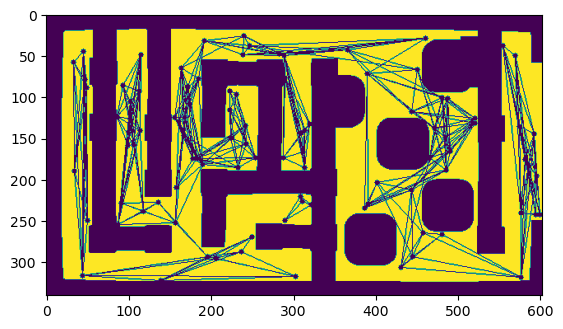

In [31]:
# Path planning based on Dijkstra
(path, cost) = dijkstra(prm_graph.edges, -1, -2)
print(f"Path: {path}, Cost: {cost}")

prm_path_image = prm_image.copy()
# Display resulting image
# 绘制路线
for i in range(len(path)):
    if i < len(path)-1:
        id_current = path[i]
        id_connected = path[i+1]
        # 当前Node的坐标
        X_current = prm_graph.nodes[id_current].x
        Y_current = prm_graph.nodes[id_current].y
        # 下一个Node的坐标
        X_connected = prm_graph.nodes[id_connected].x
        Y_connected = prm_graph.nodes[id_connected].y
        cv2.line(prm_path_image, (Y_current, X_current), (Y_connected, X_connected), (0, 0, 255), 8)
        

plt.imshow(prm_image)
plt.show()

MyCVShow(prm_path_image)
